In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
import pytorch_lightning as pl
import seaborn as sns

# Description of the target variable (number of pickup)

In [2]:
# # Ignore warnings
# import warnings
# warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('dataset/locker_nyc_engineered.csv')
# Convert Date Hour to datetime
df['Date Hour'] = pd.to_datetime(df['Date Hour'])
df['Locker Name'] = "Total Locker"
# Extract dict Locker Name -> IsIndoor
locker_indoor_dict = df.set_index('Locker Name')['IsIndoor'].to_dict()
# Cache IsHoliday per date
holiday_dict = df.groupby(df['Date Hour'].dt.date)['IsHoliday'].first().to_dict()
df.drop(columns=['IsIndoor'], inplace=True)

# Group by Locker Name, resample to 3 hours, and take the sum of numerical columns
df = df.set_index('Date Hour')
df = df.groupby('Locker Name').resample('3h').sum().drop(columns=["Locker Name"])
df = df.reset_index()
df = df.fillna(0)

# Map IsHoliday back to the resampled dataframe
df['IsHoliday'] = df['Date Hour'].dt.date.map(holiday_dict)

# Apply rolling window
for window in [1, 2]:
    df[f'withdraw_{window}'] = df.groupby('Locker Name')['size_S_withdraw'].transform(lambda x: x.shift(1).rolling(window=window, min_periods=1).sum())
    # Fill NaN values with 0
    df[f'withdraw_{window}'] = df[f'withdraw_{window}'].fillna(0)

# Apply rolling window
for window in [1, 2, 8, 16]:
    df[f'delivery_{window}'] = df.groupby('Locker Name')['size_S_delivery'].transform(lambda x: x.rolling(window=window, min_periods=1).sum())

# Proxy inventory by applying rolling window sum of withdraw - delivery
df[f'inventory'] = df[f'delivery_1'] - df[f'withdraw_1']
# Apply cumulative sum to get a proxy inventory level
df[f'inventory'] = df.groupby('Locker Name')[f'inventory'].cumsum()

# Target variable: proportion_withdraw: size_S_withdraw / inventory
df['proportion_withdraw'] = df.apply(lambda row: row['size_S_withdraw'] / row['inventory'] if row['inventory'] > 0 else 0, axis=1)
# df.drop(columns=['size_S_withdraw'], inplace=True)
# Ignore all size_*_delivery and size_*_withdraw columns except size_S_withdraw
cols_to_drop = [col for col in df.columns if ('size_' in col and col not in ['size_S_withdraw'])]
df = df.drop(columns=cols_to_drop)

# Apply the IsIndoor feature back to the resampled dataframe
df['IsIndoor'] = df['Locker Name'].map(locker_indoor_dict)

df['Hour'] = df['Date Hour'].dt.hour
# df['Day of Week'] = df['Date Hour'].dt.dayofweek
df['Month'] = df['Date Hour'].dt.month
df['IsPeakHour'] = df['Date Hour'].apply(lambda x: True if 17 <= x.hour <= 20 else False)
df['IsWeekend'] = df['Date Hour'].dt.dayofweek.apply(lambda x: True if x >= 5 else False)

# Create a time index as incremental integer
df['time_idx'] = df.groupby('Locker Name')['Date Hour'].transform(lambda x: (x - x.min()).dt.total_seconds() // 3600 / 3).astype(int)
df.head()

,Locker Name,Date Hour,size_S_withdraw,IsHoliday,withdraw_1,withdraw_2,delivery_1,delivery_2,delivery_8,delivery_16,inventory,proportion_withdraw,IsIndoor,Hour,Month,IsPeakHour,IsWeekend,time_idx
0,Total Locker,2024-04-10 12:00:00,2.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,1.0,0,12,4,False,False,0
1,Total Locker,2024-04-10 15:00:00,0.0,0.0,2.0,2.0,0.0,2.0,2.0,2.0,0.0,0.0,0,15,4,False,False,1
2,Total Locker,2024-04-10 18:00:00,1.0,0.0,0.0,2.0,10.0,10.0,12.0,12.0,10.0,0.1,0,18,4,True,False,2
3,Total Locker,2024-04-10 21:00:00,0.0,0.0,1.0,1.0,0.0,10.0,12.0,12.0,9.0,0.0,0,21,4,False,False,3
4,Total Locker,2024-04-11 00:00:00,0.0,0.0,0.0,1.0,0.0,0.0,12.0,12.0,9.0,0.0,0,0,4,False,False,4


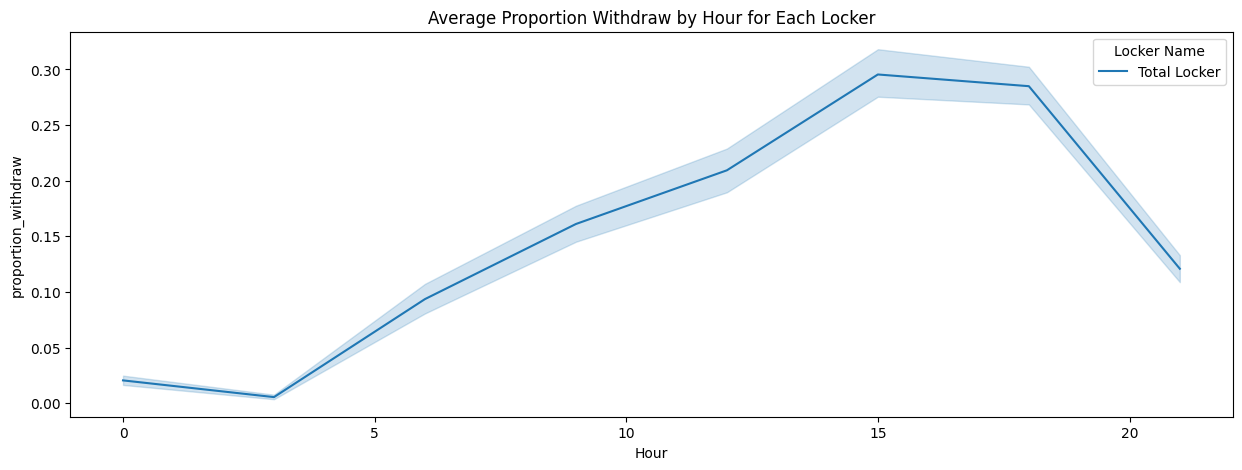

In [4]:
# Plot the proportion_withdraw, mean by hour, for each locker
plt.figure(figsize=(15, 5))
sns.lineplot(data=df, x='Hour', y='proportion_withdraw', hue='Locker Name', estimator='mean')
plt.title('Average Proportion Withdraw by Hour for Each Locker')
plt.show()

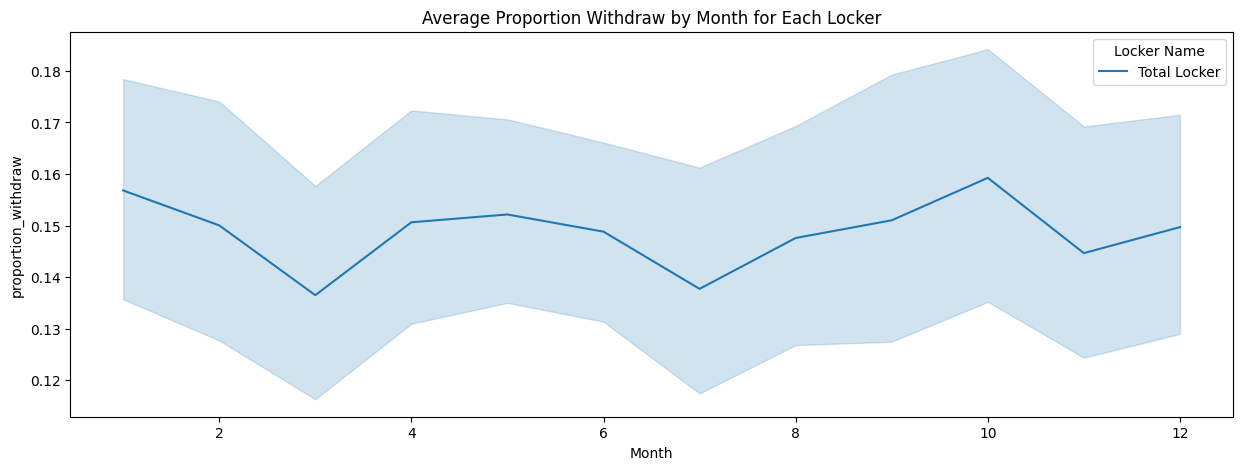

In [5]:
# Plot the proportion_withdraw, mean by hour, for each locker
plt.figure(figsize=(15, 5))
sns.lineplot(data=df, x='Month', y='proportion_withdraw', hue='Locker Name', estimator='mean')
plt.title('Average Proportion Withdraw by Month for Each Locker')
plt.show()

In [6]:
# Print the proportion of zero values in size_S_withdraw
zero_proportion = (df['proportion_withdraw'] == 0).mean()
print(f"Proportion of zero values in size_S_withdraw: {zero_proportion:.2%}")
print(f"Proportion of IsHoliday: {df['IsHoliday'].mean():.2%}")

Proportion of zero values in size_S_withdraw: 41.36%
Proportion of IsHoliday: 2.68%


In [7]:
MONTHS_IN_YEAR = 12
HOURS_IN_DAY = 24
DAYS_IN_WEEK = 7
QUARTERS_IN_YEAR = 4

df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / HOURS_IN_DAY)
df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / HOURS_IN_DAY)
# df['month_sin'] = np.sin(2 * np.pi * df['Month'] / MONTHS_IN_YEAR)
# df['month_cos'] = np.cos(2 * np.pi * df['Month'] / MONTHS_IN_YEAR)
# df['day_of_week_sin'] = np.sin(2 * np.pi * df['Day of Week'] / DAYS_IN_WEEK)
# df['day_of_week_cos'] = np.cos(2 * np.pi * df['Day of Week'] / DAYS_IN_WEEK)

df = df.drop(columns=['Hour', 'Month', 'IsHoliday'])


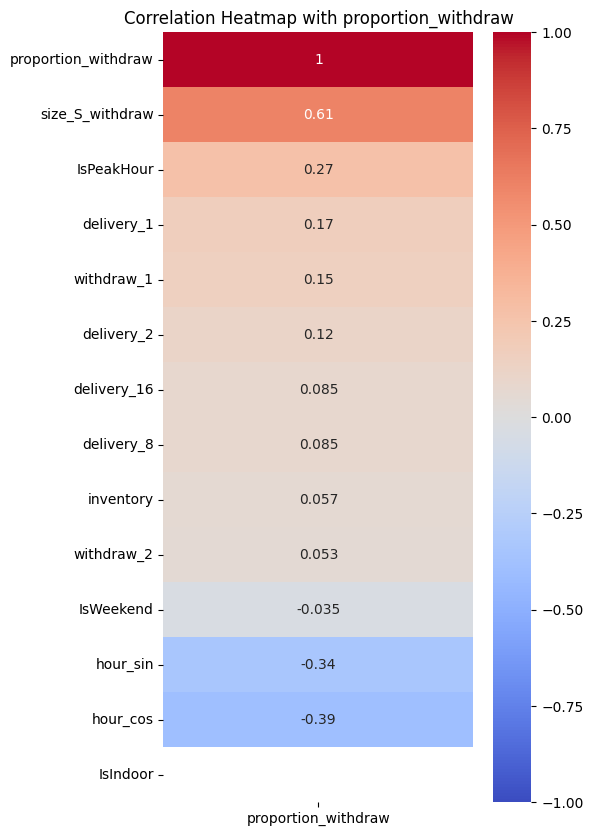

<Figure size 500x1000 with 0 Axes>

<Figure size 500x1000 with 0 Axes>

In [8]:
# Plot the correlation heatmap between size_S_withdraw and other features, except Date Hour and Locker Name
plt.figure(figsize=(5, 10))
COLUMNS_TO_EXCLUDE = ['Date Hour', 'Locker Name', 'time_idx']
df_corr = df.drop(columns=COLUMNS_TO_EXCLUDE)
sns.heatmap(df_corr.corr()[['proportion_withdraw']].sort_values(by='proportion_withdraw', ascending=False), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap with proportion_withdraw')
plt.show()
plt.figure(figsize=(5, 10))

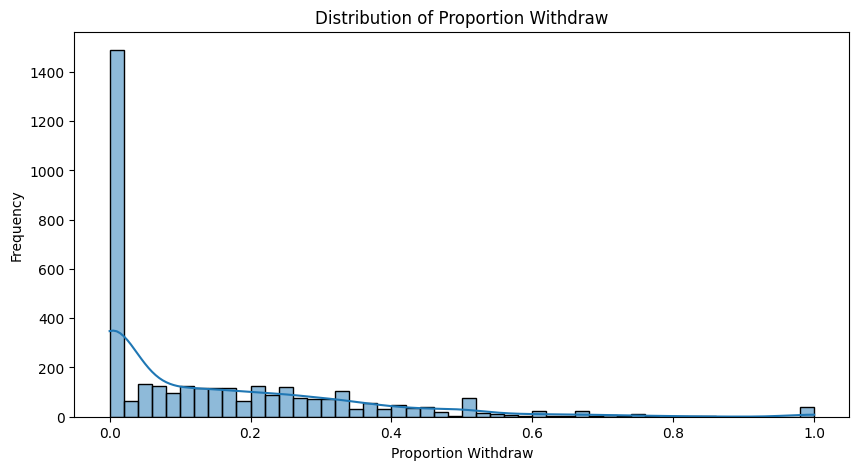

In [9]:
# Plot the proportion_withdraw distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['proportion_withdraw'], bins=50, kde=True)
plt.title('Distribution of Proportion Withdraw')
plt.xlabel('Proportion Withdraw')
plt.ylabel('Frequency')
plt.show()

In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from sklearn.preprocessing import StandardScaler
from torchmetrics import MeanSquaredError
import math

# Custom Dataset for time series data from DataFrame
class TimeSeriesDataset(Dataset):
    def __init__(self, df, encoder_length, decoder_length, target_col, feature_cols, from_train_scaler=None):
        self.encoder_length = encoder_length
        self.decoder_length = decoder_length
        self.target_col = target_col
        self.feature_cols = feature_cols
        
        # Scale features
        if from_train_scaler:
            self.scaler = from_train_scaler
            self.features = self.scaler.transform(df[feature_cols].values)
        else:
             self.scaler = StandardScaler()
             self.features = self.scaler.fit_transform(df[feature_cols].values)
        self.indices = df['time_idx'].values
        self.dates = df['Date Hour'].values
        self.targets = df[target_col].values
        
    def __len__(self):
        return len(self.features) - self.encoder_length - self.decoder_length

    def __getitem__(self, idx):
        # Get sequence of features and target
        x = self.features[idx:idx+self.encoder_length]
        y = self.targets[idx+self.encoder_length:idx+self.encoder_length+self.decoder_length]
        index = self.indices[idx+self.encoder_length:idx+self.encoder_length+self.decoder_length]
        
        return (torch.tensor(x, dtype=torch.float32), 
                torch.tensor(y, dtype=torch.float32),
                torch.tensor(index, dtype=torch.int64)
        )

class DecayMSE(nn.Module):
    def __init__(self, lambda_decay=0.1):
        super(DecayMSE, self).__init__()
        self.lambda_decay = lambda_decay
        self.mse = nn.MSELoss(reduction='none')

    def forward(self, y_pred, y_true):
        # Calculate the squared errors
        squared_errors = self.mse(y_pred, y_true)
        H = squared_errors.size(1)
        # Create decay weights: w_h = exp(-λ * h) for h = 1 to H
        decay_factors = torch.tensor([math.exp(-self.lambda_decay * i) for i in range(H)], device=squared_errors.device)
        # Apply the decay factors to the squared errors
        weighted_errors = squared_errors * decay_factors
        # Return the mean of the weighted errors
        return weighted_errors.mean()

# PyTorch Lightning LSTM Model
class LSTMModel(pl.LightningModule):
    def __init__(self, input_size, output_horizon, hidden_size, num_layers, loss=DecayMSE(), learning_rate=0.001):
        super().__init__()
        self.save_hyperparameters()
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=input_size, 
                          hidden_size=hidden_size, 
                          num_layers=num_layers, 
                          batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_horizon)
        # Apply sigmoid activation to ensure output is between 0 and 1
        self.sigmoid = nn.Sigmoid()

        # Loss function
        self.criterion = loss
        self.training_mse = MeanSquaredError()
        self.validation_mse = MeanSquaredError()

    def forward(self, x):
        # LSTM forward pass
        lstm_out, _ = self.lstm(x)
        # Take the last time step
        out = self.fc(lstm_out[:, -1, :])
        out = self.sigmoid(out)  # Ensure output is between 0 and 1
        return out
    
    def training_step(self, batch, batch_idx):
        x, y, _= batch
        y_hat = self(x)
        assert y.shape == y_hat.shape, f"Shape mismatch: y {y.shape}, y_hat {y_hat.shape}"
        loss = self.criterion(y_hat, y)
        batch_value = self.training_mse(y_hat, y)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def on_train_epoch_end(self):
        self.log('train_mse_epoch', self.training_mse.compute(), prog_bar=True)
        self.training_mse.reset()
    
    def validation_step(self, batch, batch_idx):
        x, y, _ = batch
        y_hat = self(x)
        assert y.shape == y_hat.shape, f"Shape mismatch: y {y.shape}, y_hat {y_hat.shape}"
        loss = self.criterion(y_hat, y)
        batch_value = self.validation_mse(y_hat, y)
        self.log('val_loss', loss, prog_bar=True)
        return loss

    def on_validation_epoch_end(self):
        self.log('val_mse_epoch', self.validation_mse.compute(), prog_bar=True)
        self.validation_mse.reset()

    def test_step(self, batch, batch_idx):
        x, y, _ = batch
        y_hat = self(x)
        assert y.shape == y_hat.shape, f"Shape mismatch: y {y.shape}, y_hat {y_hat.shape}"
        loss = self.criterion(y_hat, y)
        self.log('test_loss', loss)
        self.log('test_rmse', torch.sqrt(loss))
        self.log('test_mse', loss)  # Changed from MAE to MSE
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

# Function to create DataLoader from DataFrame
def create_dataloader(df, encoder_length, decoder_length, target_col, feature_cols, batch_size=32, train_val_test_split=(0.7, 0.2, 0.1), num_workers=0):
    train_split, val_split, test_split = train_val_test_split

    # Split data into train and validation
    train_size = int(train_split * len(df))
    train_df = df[:train_size]
    val_df = df[train_size:train_size + int(val_split * len(df))]
    test_df = df[train_size + int(val_split * len(df)):]
    print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")
    # Create datasets
    train_dataset = TimeSeriesDataset(train_df, encoder_length, decoder_length, target_col, feature_cols)
    val_dataset = TimeSeriesDataset(val_df, encoder_length, decoder_length, target_col, feature_cols, from_train_scaler=train_dataset.scaler)
    test_dataset = TimeSeriesDataset(test_df, encoder_length, decoder_length, target_col, feature_cols, from_train_scaler=train_dataset.scaler)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader, train_df, val_df, test_df

In [ ]:
ENCODER_LENGTH = 16
DECODER_LENGTH = 4
TARGET_COL = 'proportion_withdraw'
FEATURE_COLS = [col for col in df.columns if col not in ['Date Hour', 'Locker Name', 'proportion_withdraw', 'time_idx', 'size_S_withdraw']]
BATCH_SIZE = 128
INPUT_SIZE = len(FEATURE_COLS)
HIDDEN_SIZE = 256
NUM_LAYERS = 8
WORKERS = 8

train_loader, val_loader, test_loader, train_df, val_df, test_df = create_dataloader(
    df,
    encoder_length=ENCODER_LENGTH,
    decoder_length=DECODER_LENGTH,
    target_col=TARGET_COL,
    feature_cols=FEATURE_COLS,
    batch_size=BATCH_SIZE,
    train_val_test_split=(0.7, 0.2, 0.1),
    num_workers=WORKERS
)

Train size: 2516, Validation size: 719, Test size: 360


In [72]:

model = LSTMModel(
    input_size=INPUT_SIZE,
    output_horizon=DECODER_LENGTH,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    loss=DecayMSE(lambda_decay=0.95),
    learning_rate=1e-4
)
print(f"Model has {sum(p.numel() for p in model.parameters() if p.requires_grad)} trainable parameters")

Model has 3962888 trainable parameters


/home/aphuc/ai/workspace/pl-forecasting/.venv/lib/python3.12/site-packages/pytorch_lightning/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.


In [73]:
# Load the first batch to check for correct matching of input and output shapes
for batch in train_loader:
    x, y, idx = batch
    print(f"Input shape: {x.shape}, Target shape: {y.shape}")
    break

Input shape: torch.Size([128, 16, 12]), Target shape: torch.Size([128, 8])


In [74]:
from pytorch_lightning.callbacks import EarlyStopping

trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    min_epochs=10,
    max_epochs=500,
    callbacks=[EarlyStopping(monitor="val_loss", patience=5, mode="min")],
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [75]:
# Print the number of batches in each loader
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

Number of training batches: 20
Number of validation batches: 6


In [76]:
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type             | Params | Mode 
------------------------------------------------------------
0 | lstm           | LSTM             | 4.0 M  | train
1 | fc             | Linear           | 2.1 K  | train
2 | sigmoid        | Sigmoid          | 0      | train
3 | criterion      | DecayMSE         | 0      | train
4 | training_mse   | MeanSquaredError | 0      | train
5 | validation_mse | MeanSquaredError | 0      | train
------------------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.852    Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode

  | Name           | Type             | Params | Mode 
------------------------------------------------------------
0 | lstm           | LSTM             | 4.0 M  | train
1 | fc             | Linear           | 2.1 K  | train
2 | sigmoid        | Sigmoid  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/aphuc/ai/workspace/pl-forecasting/.venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [77]:
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.006081159692257643
        test_mse           0.006081159692257643
        test_rmse           0.07688720524311066
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.006081159692257643,
  'test_rmse': 0.07688720524311066,
  'test_mse': 0.006081159692257643}]

In [78]:
import torch
import numpy as np
from tqdm import tqdm

# Assume model is already trained and in evaluation mode
model.eval()
predictions = {h: [] for h in range(DECODER_LENGTH)}
true_values = {h: [] for h in range(DECODER_LENGTH)}
indices = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        # Extract input and target from batch
        x, y, index = batch
        # Forward pass to get predictions
        pred = model(x)  # Shape: (batch_size, DECODER_LENGTH)
        pred = pred.cpu().numpy()
        y = y.cpu().numpy()
        index = index.cpu().numpy()
        # Collect predictions and true values for each horizon
        for h in range(DECODER_LENGTH):
            predictions[h].extend(pred[:, h])
            true_values[h].extend(y[:, h])
        
        # Use the time_idx for horizon 0 (starting point) for each sample
        indices.extend(index[:, 0])

# Create DataFrame with separate columns for each horizon
df_dict = {'time_idx': indices}
for h in range(DECODER_LENGTH):
    df_dict[f'predictions_{h}'] = predictions[h]
    df_dict[f'true_values_{h}'] = true_values[h]

evaluation_df = pd.DataFrame(df_dict)
evaluation_df.head()

100%|██████████| 3/3 [00:00<00:00,  7.21it/s]


,time_idx,predictions_0,true_values_0,predictions_1,true_values_1,predictions_2,true_values_2,predictions_3,true_values_3,predictions_4,true_values_4,predictions_5,true_values_5,predictions_6,true_values_6,predictions_7,true_values_7
0,3251,0.068434,0.083333,0.042712,0.090909,0.085968,0.000000,0.164073,0.000000,0.200188,0.000000,0.194642,0.300000,0.151030,0.285714,0.103829,0.090909
1,3252,0.038036,0.090909,0.029378,0.000000,0.083841,0.000000,0.147151,0.000000,0.241209,0.300000,0.294311,0.285714,0.197153,0.090909,0.101591,0.190476
2,3253,0.038115,0.000000,0.030296,0.000000,0.085726,0.000000,0.148859,0.300000,0.243861,0.285714,0.294821,0.090909,0.196756,0.190476,0.102327,0.000000
3,3254,0.101143,0.000000,0.144055,0.000000,0.195749,0.300000,0.270667,0.285714,0.200065,0.090909,0.123818,0.190476,0.136194,0.000000,0.108488,0.000000
4,3255,0.153020,0.000000,0.207876,0.300000,0.285397,0.285714,0.273505,0.090909,0.141527,0.190476,0.089027,0.000000,0.133678,0.000000,0.120998,0.117647


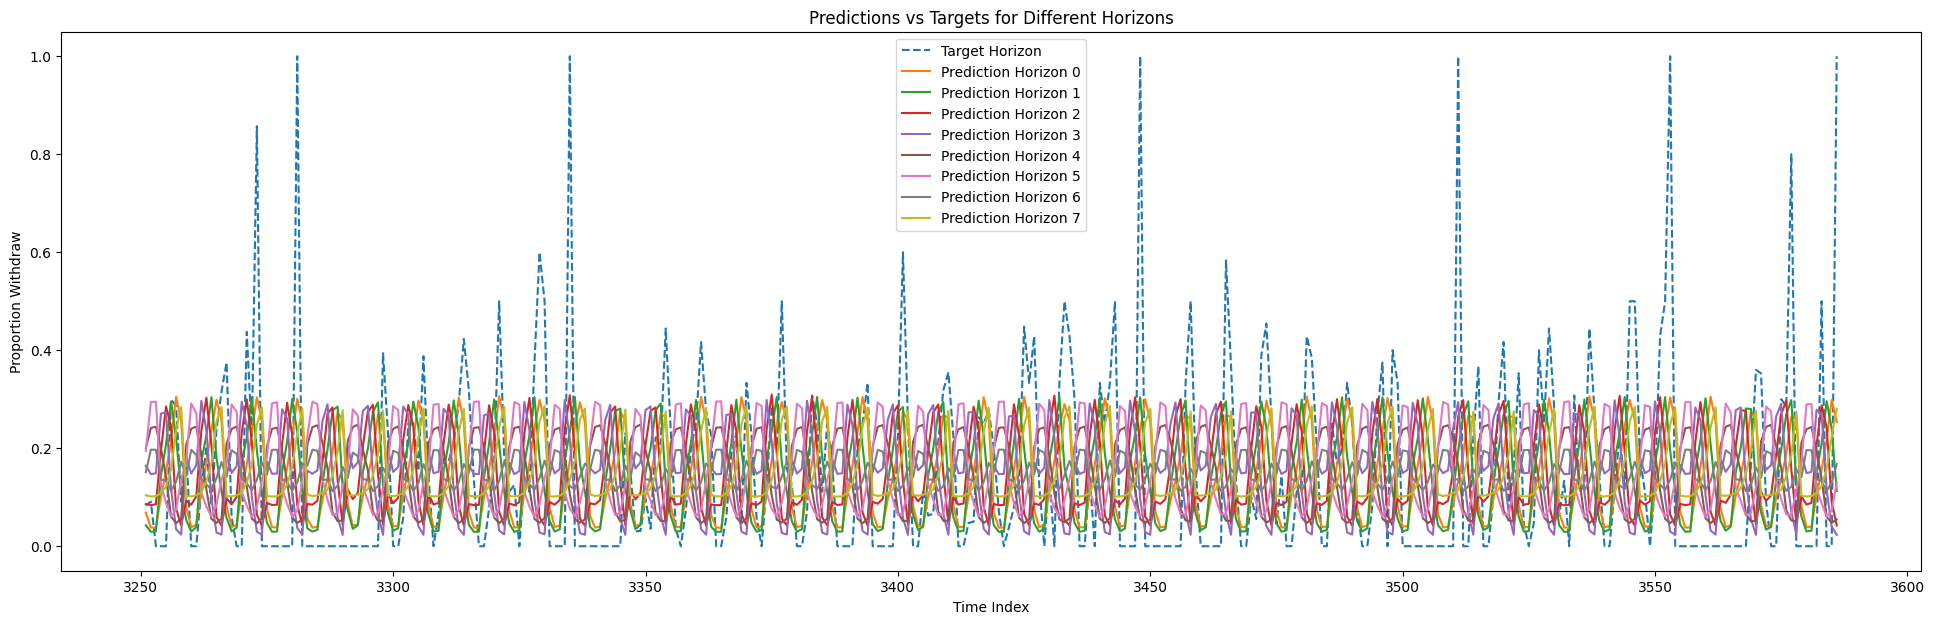

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot predictions vs targets with lines for different horizons using different colors
plt.figure(figsize=(24, 7))
plt.plot(evaluation_df['time_idx'], evaluation_df[f'true_values_0'], label=f'Target Horizon', linestyle='--')
for h in range(DECODER_LENGTH):
    plt.plot(evaluation_df['time_idx'], evaluation_df[f'predictions_{h}'], label=f'Prediction Horizon {h}')
plt.legend()
plt.title('Predictions vs Targets for Different Horizons')
plt.xlabel('Time Index')
plt.ylabel('Proportion Withdraw')
plt.show()

In [80]:
# Format the predicted_withdraw column to integer by multiplying with inventory, for each horizon
merged_df = pd.merge(evaluation_df, test_df[['time_idx', 'Date Hour', 'Locker Name', 'inventory', 'size_S_withdraw']], on='time_idx', how='left')
# rename size_S_withdraw to true_withdraw
merged_df = merged_df.rename(columns={'size_S_withdraw': 'true_withdraw_h0'})
for h in range(DECODER_LENGTH):
    merged_df[f'predicted_withdraw_h{h}'] = merged_df[f'predictions_{h}'] * merged_df['inventory']
    # Round predicted_withdraw to integer
    merged_df[f'predicted_withdraw_h{h}'] = merged_df[f'predicted_withdraw_h{h}'].round().astype(int)

# Add true_withdraw for future horizons by shifting true_withdraw_h0
for h in range(1, DECODER_LENGTH):
    merged_df[f'true_withdraw_h{h}'] = merged_df['true_withdraw_h0'].shift(-h).fillna(0).astype(int)

merged_df.head(10)

,time_idx,predictions_0,true_values_0,predictions_1,true_values_1,predictions_2,true_values_2,predictions_3,true_values_3,predictions_4,...,predicted_withdraw_h5,predicted_withdraw_h6,predicted_withdraw_h7,true_withdraw_h1,true_withdraw_h2,true_withdraw_h3,true_withdraw_h4,true_withdraw_h5,true_withdraw_h6,true_withdraw_h7
0,3251,0.068434,0.083333,0.042712,0.090909,0.085968,0.000000,0.164073,0.000000,0.200188,...,2,2,1,1,0,0,0,3,2,1
1,3252,0.038036,0.090909,0.029378,0.000000,0.083841,0.000000,0.147151,0.000000,0.241209,...,3,2,1,0,0,0,3,2,1,4
2,3253,0.038115,0.000000,0.030296,0.000000,0.085726,0.000000,0.148859,0.300000,0.243861,...,3,2,1,0,0,3,2,1,4,0
3,3254,0.101143,0.000000,0.144055,0.000000,0.195749,0.300000,0.270667,0.285714,0.200065,...,1,1,1,0,3,2,1,4,0,0
4,3255,0.153020,0.000000,0.207876,0.300000,0.285397,0.285714,0.273505,0.090909,0.141527,...,1,1,1,3,2,1,4,0,0,2
5,3256,0.215729,0.300000,0.295572,0.285714,0.244322,0.090909,0.116799,0.190476,0.060260,...,1,1,2,2,1,4,0,0,2,3
6,3257,0.305122,0.285714,0.221433,0.090909,0.077536,0.190476,0.034544,0.000000,0.047152,...,1,1,2,1,4,0,0,2,3,1
7,3258,0.256108,0.090909,0.111065,0.190476,0.042318,0.000000,0.023845,0.000000,0.056248,...,1,2,3,4,0,0,2,3,1,5
8,3259,0.080365,0.190476,0.053675,0.000000,0.092885,0.000000,0.181525,0.117647,0.207393,...,4,3,2,0,0,2,3,1,5,6
9,3260,0.038873,0.000000,0.029870,0.000000,0.084765,0.117647,0.148448,0.200000,0.239976,...,5,3,2,0,2,3,1,5,6,9


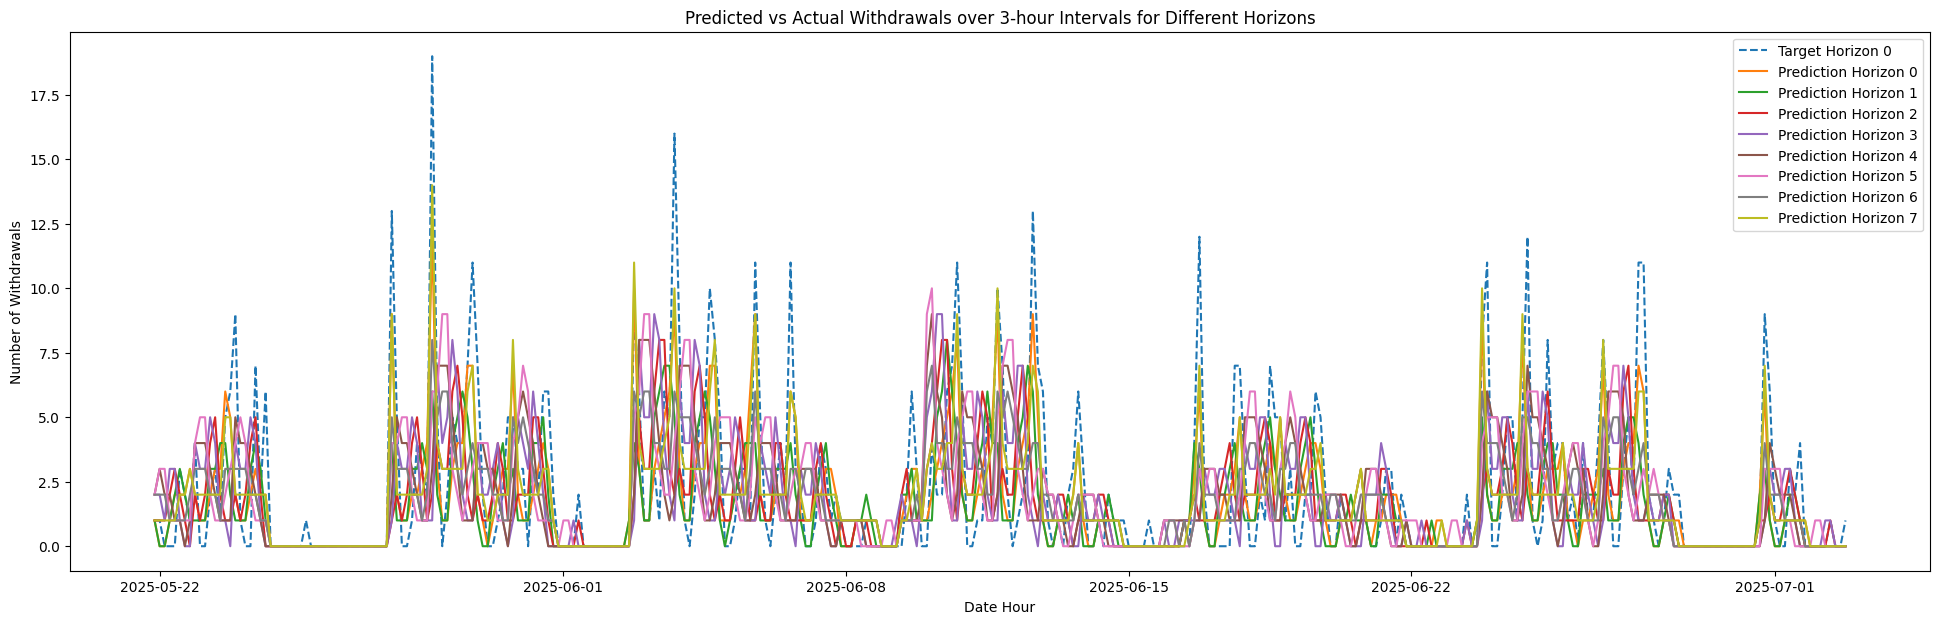

In [81]:
# Plot the predicted_withdraw and true_withdraw for each horizon, using different colors
plt.figure(figsize=(24, 7))
plt.plot(merged_df['Date Hour'], merged_df['true_withdraw_h0'], label=f'Target Horizon 0', linestyle='--')
for h in range(DECODER_LENGTH):
    plt.plot(merged_df['Date Hour'], merged_df[f'predicted_withdraw_h{h}'], label=f'Prediction Horizon {h}')
plt.title('Predicted vs Actual Withdrawals over 3-hour Intervals for Different Horizons')
plt.xlabel('Date Hour')
plt.ylabel('Number of Withdrawals')
plt.legend()
plt.show()

In [82]:
# Plot the predictions histogram
plt.figure(figsize=(10, 5))
sns.histplot(merged_df['predictions'], bins=50, kde=True)
plt.title('Distribution of Predicted Withdraw')
plt.xlabel('Predicted Withdraw')
plt.ylabel('Frequency')
plt.show()

KeyError: 'predictions'

<Figure size 1000x500 with 0 Axes>

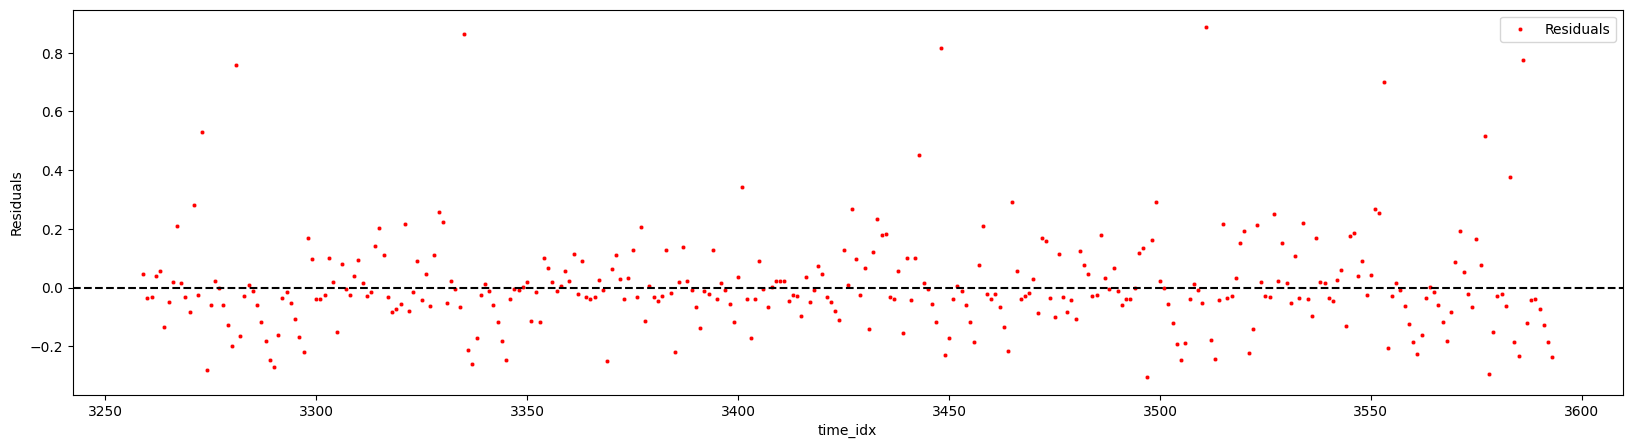

In [ ]:
# Plot the residuals

residuals = evaluation_df['true_values'] - evaluation_df['predictions']
plt.figure(figsize=(20, 5))
sns.scatterplot(x=evaluation_df['time_idx'], y=residuals, label='Residuals', color='red', s=10)
plt.axhline(0, color='black', linestyle='--')
plt.ylabel('Residuals')
plt.legend()
plt.show()

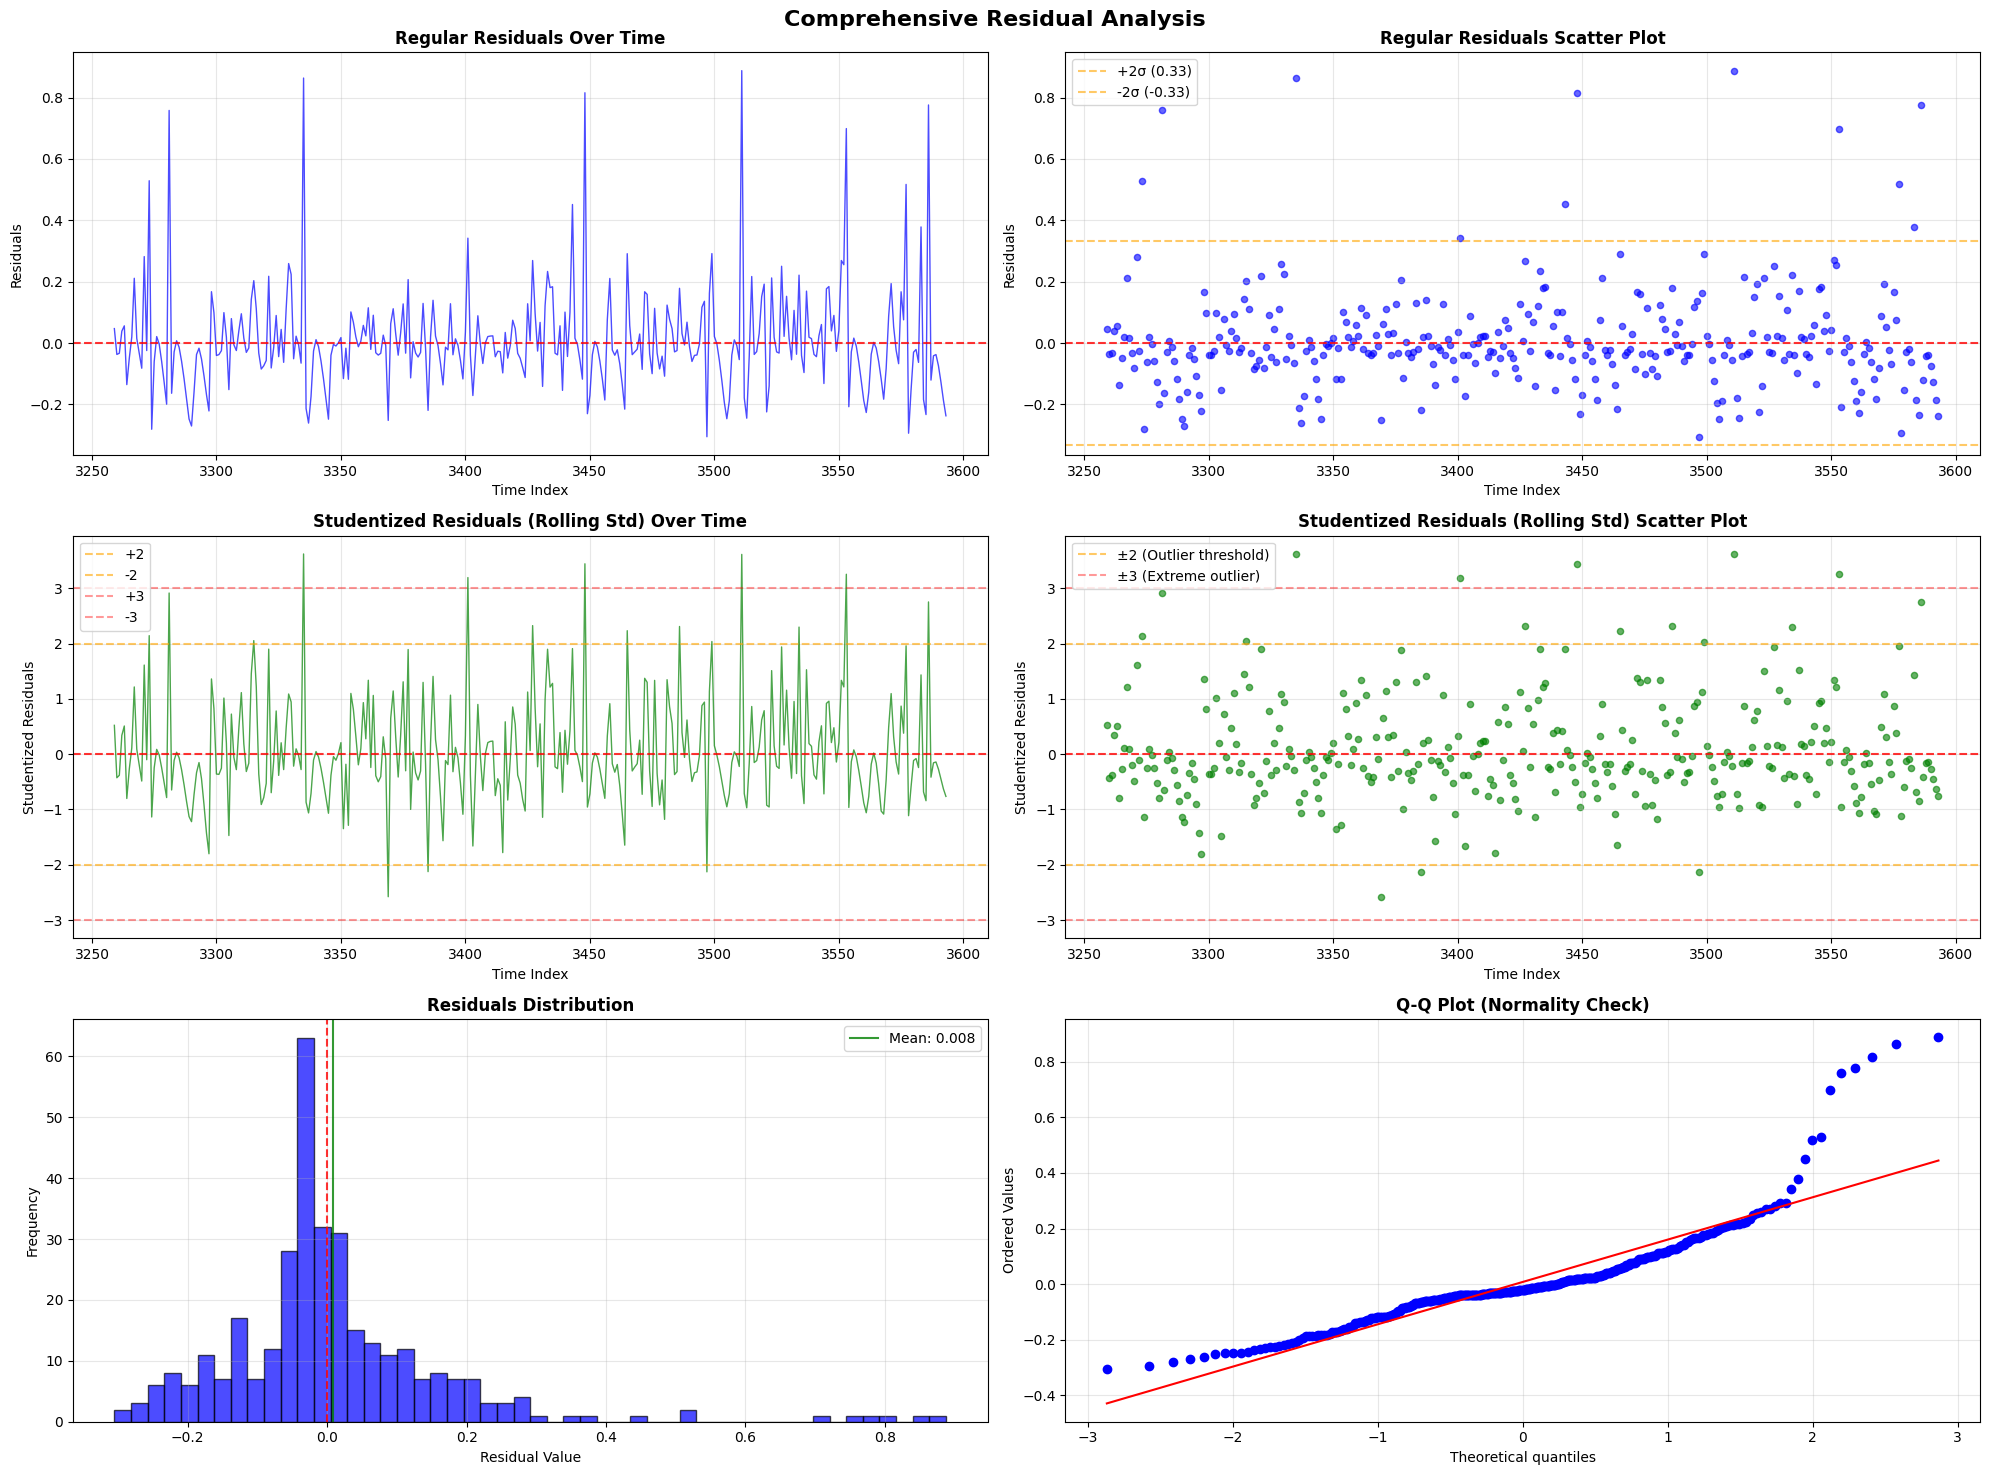

RESIDUAL ANALYSIS SUMMARY
Number of observations: 335
Mean of residuals: 0.0080
Standard deviation of residuals: 0.1663
Min residual: -0.3053
Max residual: 0.8878
Skewness: 2.1366
Kurtosis: 8.1441

Outlier Analysis (Studentized Residuals):
Points beyond ±2σ: 17 (5.1%)
Points beyond ±3σ: 5 (1.5%)

Extreme outlier time indices: [3335 3401 3448 3511 3553]


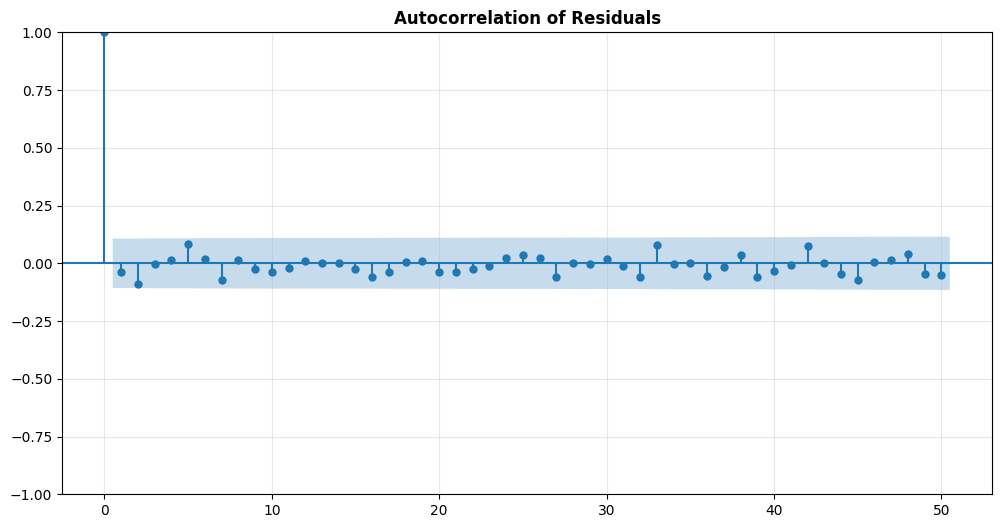


Autocorrelation analysis helps identify if residuals have temporal patterns.
Significant autocorrelation indicates the model may not capture all temporal dependencies.


In [ ]:
# Enhanced Residual Analysis: Regular and Studentized Residuals

import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

# Calculate residuals
residuals = evaluation_df['true_values'] - evaluation_df['predictions']

# Calculate studentized residuals
# Studentized residuals = residuals / sqrt(MSE * (1 - h_ii))
# where h_ii is the leverage (diagonal of hat matrix)

# For simplicity, we'll use a rolling standard deviation approach
# This approximates studentized residuals for time series data
residual_std = residuals.rolling(window=20, center=True, min_periods=5).std()
studentized_residuals = residuals / (residual_std + 1e-8)  # Add small epsilon to avoid division by zero

# Alternative: Use overall standard deviation for studentized residuals
overall_std = residuals.std()
studentized_residuals_simple = residuals / overall_std

# Create comprehensive residual analysis plots
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.suptitle('Comprehensive Residual Analysis', fontsize=16, fontweight='bold')

# 1. Regular Residuals Time Series
axes[0, 0].plot(evaluation_df['time_idx'], residuals, 'b-', alpha=0.7, linewidth=1)
axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.8)
axes[0, 0].set_title('Regular Residuals Over Time', fontweight='bold')
axes[0, 0].set_xlabel('Time Index')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].grid(True, alpha=0.3)

# 2. Regular Residuals Scatter Plot
axes[0, 1].scatter(evaluation_df['time_idx'], residuals, alpha=0.6, s=20, color='blue')
axes[0, 1].axhline(y=0, color='red', linestyle='--', alpha=0.8)
axes[0, 1].axhline(y=2*np.std(residuals), color='orange', linestyle='--', alpha=0.6, label=f'+2σ ({2*np.std(residuals):.2f})')
axes[0, 1].axhline(y=-2*np.std(residuals), color='orange', linestyle='--', alpha=0.6, label=f'-2σ ({-2*np.std(residuals):.2f})')
axes[0, 1].set_title('Regular Residuals Scatter Plot', fontweight='bold')
axes[0, 1].set_xlabel('Time Index')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Studentized Residuals (Rolling Std) Time Series
axes[1, 0].plot(evaluation_df['time_idx'], studentized_residuals, 'g-', alpha=0.7, linewidth=1)
axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.8)
axes[1, 0].axhline(y=2, color='orange', linestyle='--', alpha=0.6, label='+2')
axes[1, 0].axhline(y=-2, color='orange', linestyle='--', alpha=0.6, label='-2')
axes[1, 0].axhline(y=3, color='red', linestyle='--', alpha=0.4, label='+3')
axes[1, 0].axhline(y=-3, color='red', linestyle='--', alpha=0.4, label='-3')
axes[1, 0].set_title('Studentized Residuals (Rolling Std) Over Time', fontweight='bold')
axes[1, 0].set_xlabel('Time Index')
axes[1, 0].set_ylabel('Studentized Residuals')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Studentized Residuals (Rolling Std) Scatter Plot
axes[1, 1].scatter(evaluation_df['time_idx'], studentized_residuals, alpha=0.6, s=20, color='green')
axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.8)
axes[1, 1].axhline(y=2, color='orange', linestyle='--', alpha=0.6, label='±2 (Outlier threshold)')
axes[1, 1].axhline(y=-2, color='orange', linestyle='--', alpha=0.6)
axes[1, 1].axhline(y=3, color='red', linestyle='--', alpha=0.4, label='±3 (Extreme outlier)')
axes[1, 1].axhline(y=-3, color='red', linestyle='--', alpha=0.4)
axes[1, 1].set_title('Studentized Residuals (Rolling Std) Scatter Plot', fontweight='bold')
axes[1, 1].set_xlabel('Time Index')
axes[1, 1].set_ylabel('Studentized Residuals')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 5. Residuals Distribution Histogram
axes[2, 0].hist(residuals, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[2, 0].axvline(x=0, color='red', linestyle='--', alpha=0.8)
axes[2, 0].axvline(x=np.mean(residuals), color='green', linestyle='-', alpha=0.8, label=f'Mean: {np.mean(residuals):.3f}')
axes[2, 0].set_title('Residuals Distribution', fontweight='bold')
axes[2, 0].set_xlabel('Residual Value')
axes[2, 0].set_ylabel('Frequency')
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)

# 6. Q-Q Plot for Normality Check
stats.probplot(residuals, dist="norm", plot=axes[2, 1])
axes[2, 1].set_title('Q-Q Plot (Normality Check)', fontweight='bold')
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical Summary
print("=" * 60)
print("RESIDUAL ANALYSIS SUMMARY")
print("=" * 60)
print(f"Number of observations: {len(residuals)}")
print(f"Mean of residuals: {np.mean(residuals):.4f}")
print(f"Standard deviation of residuals: {np.std(residuals):.4f}")
print(f"Min residual: {np.min(residuals):.4f}")
print(f"Max residual: {np.max(residuals):.4f}")
print(f"Skewness: {stats.skew(residuals):.4f}")
print(f"Kurtosis: {stats.kurtosis(residuals):.4f}")

# Outlier detection using studentized residuals
outliers_2sigma = np.abs(studentized_residuals) > 2
outliers_3sigma = np.abs(studentized_residuals) > 3

print(f"\nOutlier Analysis (Studentized Residuals):")
print(f"Points beyond ±2σ: {np.sum(outliers_2sigma)} ({100*np.mean(outliers_2sigma):.1f}%)")
print(f"Points beyond ±3σ: {np.sum(outliers_3sigma)} ({100*np.mean(outliers_3sigma):.1f}%)")

# Identify potential outlier time indices
if np.sum(outliers_3sigma) > 0:
    outlier_indices = evaluation_df['time_idx'][outliers_3sigma].values
    print(f"\nExtreme outlier time indices: {outlier_indices[:10]}{'...' if len(outlier_indices) > 10 else ''}")

# Autocorrelation of residuals (for time series)
from statsmodels.graphics.tsaplots import plot_acf
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(residuals, lags=50, ax=ax, alpha=0.05)
ax.set_title('Autocorrelation of Residuals', fontweight='bold')
ax.grid(True, alpha=0.3)
plt.show()

print("\nAutocorrelation analysis helps identify if residuals have temporal patterns.")
print("Significant autocorrelation indicates the model may not capture all temporal dependencies.")